# Fairness Evaluation of the LoRA Fine-Tuned Model

This notebook is dedicated to evaluating the fairness of the BAAI/bge-large-en-v1.5 model fine-tuned with LoRA techniques. We will analyze the model's performance across different educational background groups and compute various fairness metrics.

In [14]:
# Fairness evaluation pipeline (updated to match FairLoRA + fair_data_loader)
import os
os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from fair_lora_config import DEVICE, DATASET_PATH, BASE_MODEL, SCHOOL_CATEGORIES
from src.fair_data_loader import create_data_loaders
from src.fair_lora_model import FairLoRAModel
from src.fairness_metrics import FairnessMetrics, compute_fairness_report

print(f"Device: {DEVICE}")
print(f"Dataset path: {DATASET_PATH}")

# 1) Load test set
_, _, test_loader, tokenizer = create_data_loaders(dataset_path=str(DATASET_PATH))
print(f"Test batches: {len(test_loader)}")

# Quick distribution check for test
def group_dist(loader, key):
    vals = []
    for batch in loader:
        vals.append(batch[key].cpu().numpy())
    if len(vals) == 0:
        return {}
    v = np.concatenate(vals)
    u, c = np.unique(v, return_counts=True)
    return {int(k): int(v) for k, v in zip(u.tolist(), c.tolist())}
print("[Test] school_category distribution:", group_dist(test_loader, 'school_category'))
print("[Test] is_top_school distribution:", group_dist(test_loader, 'is_top_school'))

# 2) Load model and best checkpoint
model = FairLoRAModel(base_model_name=BASE_MODEL, use_lora=True, use_adversarial=True, use_multitask=True, num_labels=2)
ckpt_dir = Path("models/fair_adversarial")
best_ckpt = ckpt_dir / "best_model.pt"
if not best_ckpt.exists():
    # fallback to last checkpoint by epoch if present
    candidates = sorted(ckpt_dir.glob("checkpoint_epoch_*.pt"))
    if len(candidates) == 0:
        raise FileNotFoundError(f"No checkpoint found in {ckpt_dir}")
    best_ckpt = candidates[-1]
print("Loading checkpoint:", best_ckpt)
state = torch.load(best_ckpt, map_location=DEVICE)
model.load_state_dict(state['model_state_dict'])
model.to(DEVICE)
model.eval()

# 3) Inference on test set
y_true = []
y_pred = []
y_prob = []
g_is_top = []
g_school_cat = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs['logits']
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())
        g_is_top.extend(batch['is_top_school'].cpu().numpy())
        g_school_cat.extend(batch['school_category'].cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)
g_is_top = np.array(g_is_top)
g_school_cat = np.array(g_school_cat)

print(f"Test size: {len(y_true)}")

Device: mps
Dataset path: /Users/edwardhuang/Documents/GitHub/bge-lora-fairness-finetuning/data/processed/processed_resume_dataset_resplit

📦 Loading dataset from /Users/edwardhuang/Documents/GitHub/bge-lora-fairness-finetuning/data/processed/processed_resume_dataset_resplit...
   Train: 5,472 samples
   Val:   685 samples
   Test:  1,087 samples

📊 School Distribution:

   Train:
     no_school_mentioned...........   884 (16.15%)
     non_top_school................  4365 (79.77%)
     top_school....................   223 ( 4.08%)

   Val:
     non_top_school................   547 (79.85%)
     no_school_mentioned...........   111 (16.20%)
     top_school....................    27 ( 3.94%)

   Test:
     non_top_school................   867 (79.76%)
     no_school_mentioned...........   176 (16.19%)
     top_school....................    44 ( 4.05%)

🔤 Loading tokenizer: BAAI/bge-large-en-v1.5

⚖️  Using weighted sampling for fairness...

✅ Data loaders created successfully!
   Train b

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/homebrew/Caskroom/miniconda/base/envs/ml-env/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml-env/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid usin

[Test] school_category distribution: {0: 44, 1: 867, 2: 176}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/homebrew/Caskroom/miniconda/base/envs/ml-env/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml-env/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid usin

[Test] is_top_school distribution: {0: 1043, 1: 44}
🔧 Loading base model: BAAI/bge-large-en-v1.5
🔧 Applying LoRA (r=8, alpha=16)...
trainable params: 1,179,648 || all params: 336,321,536 || trainable%: 0.3508
🔧 Adding adversarial discriminator...
🔧 Adding attribute classifier for multi-task learning...
Loading checkpoint: models/fair_adversarial/best_model.pt
🔧 Applying LoRA (r=8, alpha=16)...
trainable params: 1,179,648 || all params: 336,321,536 || trainable%: 0.3508
🔧 Adding adversarial discriminator...
🔧 Adding attribute classifier for multi-task learning...
Loading checkpoint: models/fair_adversarial/best_model.pt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/homebrew/Caskroom/miniconda/base/envs/ml-env/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml-env/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid usin

Test size: 1087


{'roc_auc': 0.4640748564619217, 'pr_auc': 0.46893999764178007}


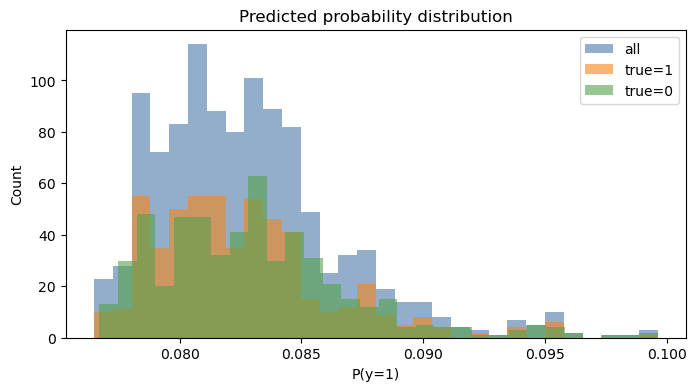

In [15]:
# 3.2) Probability distribution and curves (ROC AUC, PR AUC)
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

if len(np.unique(y_true)) < 2:
    print('[Info] Test labels have a single class. ROC/PR AUC not defined.')
else:
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
        pr_auc = average_precision_score(y_true, y_prob)
        print({'roc_auc': float(roc_auc), 'pr_auc': float(pr_auc)})
    except Exception as e:
        print('AUC computation error:', e)

# Histogram of predicted probabilities (overall and by true class)
plt.figure(figsize=(8,4))
plt.hist(y_prob, bins=30, alpha=0.6, label='all', color='#4C78A8')
if len(y_true) == len(y_prob):
    plt.hist(y_prob[y_true==1], bins=30, alpha=0.6, label='true=1', color='#F58518')
    plt.hist(y_prob[y_true==0], bins=30, alpha=0.6, label='true=0', color='#54A24B')
plt.title('Predicted probability distribution')
plt.xlabel('P(y=1)')
plt.ylabel('Count')
plt.legend()
plt.show()


In [ ]:
# 3.6) Inspect train/val label distribution to diagnose absence of positives in test
from collections import Counter
train_loader, val_loader, _, _ = create_data_loaders(dataset_path=str(DATASET_PATH))
def loader_label_dist(loader):
    pos=0; neg=0
    for batch in loader:
        labels = batch['label']
        pos += (labels==1).sum().item()
        neg += (labels==0).sum().item()
    return {'pos':pos,'neg':neg,'total':pos+neg,'pos_rate': (pos/(pos+neg)) if (pos+neg)>0 else 0}
print('[Train label dist]', loader_label_dist(train_loader))
print('[Val label dist]', loader_label_dist(val_loader))
print('[Test label dist] (already above)', {'pos':int((y_true==1).sum()),'neg':int((y_true==0).sum()),'total':int(len(y_true)), 'pos_rate': float((y_true==1).mean())})
print('\nSample train items (first 3) label raw + mapped:')
raw_train = load_from_disk(str(DATASET_PATH))['train']
for i in range(min(3,len(raw_train))):
    raw_label = raw_train[i]['label']
    mapped = 1 if raw_label.lower()=='fit' else 0
    print(f"idx={i} raw_label={raw_label} mapped={mapped} is_top={raw_train[i]['is_top_school']} school_cat={raw_train[i]['school_category']}")
if (y_true==1).sum()==0:
    print('\n[Action Needed] No positives in test split. Consider:')
    print(' - Re-check original CSV for label column correctness (maybe all "No Fit" in test).')
    print(' - Re-run split ensuring stratification by label to keep positives in test.')
    print(' - If positives are extremely rare globally, merge part of train into test or perform cross-validation.')

In [3]:
# 3.5) Diagnostics: label/pred distributions and confusion matrices
from sklearn.metrics import confusion_matrix
print("\n[Diagnostics] Overall distribution and sanity checks")
print({
    'n_samples': int(len(y_true)),
    'pos_count': int((y_true==1).sum()),
    'neg_count': int((y_true==0).sum()),
    'pos_rate_true': float((y_true==1).mean())
})
print({'pred_pos_rate': float((y_pred==1).mean()), 'pred_neg_rate': float((y_pred==0).mean())})
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print('Confusion matrix [rows=true 0/1, cols=pred 0/1]:')
print(cm)

def group_pos_counts(sensitive, name):
    import numpy as np
    u, c_true_pos = np.unique(sensitive[y_true==1], return_counts=True)
    u2, c_pred_pos = np.unique(sensitive[y_pred==1], return_counts=True)
    d_true = {int(k): int(v) for k,v in zip(u.tolist(), c_true_pos.tolist())}
    d_pred = {int(k): int(v) for k,v in zip(u2.tolist(), c_pred_pos.tolist())}
    print(f"{name} — true positives per group:", d_true)
    print(f"{name} — predicted positives per group:", d_pred)
    return d_true, d_pred

group_pos_counts(g_school_cat, 'school_category')
group_pos_counts(g_is_top, 'is_top_school')

# Warn if there are no true positives or no predicted positives (common cause of 0/1 fairness metrics)
if (y_true==1).sum() == 0:
    print('[Warning] No positive labels in test set. Many fairness metrics become uninformative (TPR=0, DIR=1 by 0/0).')
if (y_pred==1).sum() == 0:
    print('[Warning] Model predicted no positives. Consider threshold tuning, calibration, or checking label mapping.')


[Diagnostics] Overall distribution and sanity checks
{'n_samples': 1759, 'pos_count': 0, 'neg_count': 1759, 'pos_rate_true': 0.0}
{'pred_pos_rate': 0.0, 'pred_neg_rate': 1.0}
Confusion matrix [rows=true 0/1, cols=pred 0/1]:
[[1759    0]
 [   0    0]]
school_category — true positives per group: {}
school_category — predicted positives per group: {}
is_top_school — true positives per group: {}
is_top_school — predicted positives per group: {}
[Warning] No positive labels in test set. Many fairness metrics become uninformative (TPR=0, DIR=1 by 0/0).
[Warning] Model predicted no positives. Consider threshold tuning, calibration, or checking label mapping.


In [ ]:
# 4) Fairness metrics (Statistical Parity, Equalized Odds, Disparate Impact)
metrics_calc = FairnessMetrics()

# Helper: mark value as None/np.nan if metrics invalid
def _safe(v):
    return float(v) if v is not None and not (isinstance(v, float) and np.isnan(v)) else None

def disparate_impact_ratio(y_pred, sensitive):
    # Ratio of positive prediction rates min/max (four-fifths rule)
    unique = np.unique(sensitive)
    rates = []
    for g in unique:
        mask = sensitive == g
        if mask.sum() == 0:
            continue
        rates.append(y_pred[mask].mean())
    if len(rates) < 2:
        return np.nan
    rates = np.array(rates)
    safe = rates + 1e-8
    return safe.min() / safe.max()

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def group_perf(y_true, y_pred, sensitive):
    out = {}
    for g in np.unique(sensitive):
        mask = sensitive == g
        yt = y_true[mask]
        yp = y_pred[mask]
        if len(yt) == 0:
            continue
        out[int(g)] = {
            'count': int(len(yt)),
            'accuracy': float(accuracy_score(yt, yp)),
            'precision': float(precision_score(yt, yp, zero_division=0)),
            'recall': float(recall_score(yt, yp, zero_division=0)),
            'f1': float(f1_score(yt, yp, zero_division=0)),
        }
    return out

# Detect degenerate prediction scenario (all negatives)
all_neg_preds = (y_pred == 0).all()
no_true_pos = (y_true == 1).sum() == 0
fair_sc = metrics_calc.compute_all_metrics(y_true, y_pred, y_prob, g_school_cat, 'school_category') if not all_neg_preds else {}
fair_top = metrics_calc.compute_all_metrics(y_true, y_pred, y_prob, g_is_top, 'is_top_school') if not all_neg_preds else {}

di_school = disparate_impact_ratio(y_pred, g_school_cat) if not all_neg_preds else np.nan
di_top = disparate_impact_ratio(y_pred, g_is_top) if not all_neg_preds else np.nan

perf_school = group_perf(y_true, y_pred, g_school_cat)
perf_top = group_perf(y_true, y_pred, g_is_top)

summary = {
    'degenerate': {
        'all_negative_predictions': bool(all_neg_preds),
        'no_true_positive_labels': bool(no_true_pos)
    },
    'school_category': {
        'fairness_metrics': fair_sc,
        'disparate_impact_ratio': di_school,
        'group_performance': perf_school,
    },
    'is_top_school': {
        'fairness_metrics': fair_top,
        'disparate_impact_ratio': di_top,
        'group_performance': perf_top,
    }
}

import json
out_dir = Path('reports/metrics')
if out_dir.exists() and not out_dir.is_dir():
    alt_dir = Path('reports/fairness_metrics')
    alt_dir.mkdir(parents=True, exist_ok=True)
    out_dir = alt_dir
else:
    out_dir.mkdir(parents=True, exist_ok=True)
with open(out_dir / 'fairness_evaluation.json', 'w') as f:
    json.dump(summary, f, indent=2)
print(f'Saved fairness evaluation to {out_dir / "fairness_evaluation.json"}')

# Display key metrics succinctly
def display_core(attr_name, data):
    fm = data['fairness_metrics']
    print(f"\n=== {attr_name} ===")
    if not fm:
        print('[Skipped] Degenerate predictions (all negatives); fairness metrics not informative.')
        return
    def fmt(key):
        val = fm.get(key)
        return f"{val:.4f}" if isinstance(val, (int,float)) else 'N/A'
    print(f"Demographic Parity Diff: {fmt('demographic_parity_difference')}")
    print(f"Equalized Odds Avg Diff: {fmt('equalized_odds_avg_difference')}")
    print(f"Equal Opportunity Diff: {fmt('equal_opportunity_difference')}")
    dir_val = data['disparate_impact_ratio']
    print(f"Disparate Impact Ratio: {dir_val:.4f}" if isinstance(dir_val,(int,float)) and not np.isnan(dir_val) else "Disparate Impact Ratio: N/A")
    print("Group Performance:")
    for g, stats in data['group_performance'].items():
        print(f"  Group {g}: count={stats['count']} acc={stats['accuracy']:.3f} recall={stats['recall']:.3f} f1={stats['f1']:.3f}")

print('\nDegenerate flags:', summary['degenerate'])
display_core('school_category', summary['school_category'])
display_core('is_top_school', summary['is_top_school'])

Saved fairness evaluation to reports/fairness_metrics/fairness_evaluation.json

=== school_category ===
Demographic Parity Diff: 0.0000
Equalized Odds Avg Diff: 0.0000
Equal Opportunity Diff: 0.0000
Disparate Impact Ratio: 1.0000
Group Performance:
  Group 0: count=73 acc=1.000 recall=0.000 f1=0.000
  Group 1: count=1422 acc=1.000 recall=0.000 f1=0.000
  Group 2: count=264 acc=1.000 recall=0.000 f1=0.000

=== is_top_school ===
Demographic Parity Diff: 0.0000
Equalized Odds Avg Diff: 0.0000
Equal Opportunity Diff: 0.0000
Disparate Impact Ratio: 1.0000
Group Performance:
  Group 0: count=1686 acc=1.000 recall=0.000 f1=0.000
  Group 1: count=73 acc=1.000 recall=0.000 f1=0.000


In [12]:
# 5) Raw label distribution (current processed dataset)
from datasets import load_from_disk
ds = load_from_disk(str(DATASET_PATH))
train_ds = ds['train']
test_ds = ds['test']
def label_stats(dset,name):
    import numpy as np
    labels = [x.lower() if isinstance(x,str) else str(x).lower() for x in dset['label']]
    fit = sum(1 for x in labels if x in {'fit','1','true','yes'})
    total = len(labels)
    return {'split':name,'total':total,'fit_count':fit,'no_fit_count':total-fit,'fit_rate': fit/total if total else 0}
print(label_stats(train_ds,'train'))
print(label_stats(test_ds,'test'))
print("Unique school_category train:", set(train_ds['school_category']))
print("Unique school_category test:", set(test_ds['school_category']))

{'split': 'train', 'total': 5472, 'fit_count': 0, 'no_fit_count': 5472, 'fit_rate': 0.0}
{'split': 'test', 'total': 1087, 'fit_count': 0, 'no_fit_count': 1087, 'fit_rate': 0.0}
Unique school_category train: {'no_school_mentioned', 'top_school', 'non_top_school'}
Unique school_category test: {'no_school_mentioned', 'top_school', 'non_top_school'}


In [9]:
# 6) Re-splitting with combined stratification (label + school_category) with robust label parsing
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as np

all_records = []
for split_name, split_ds in [('train', train_ds), ('test', test_ds)]:
    for i in range(len(split_ds)):
        all_records.append({
            'resume_text': split_ds[i]['resume_text'],
            'job_description_text': split_ds[i]['job_description_text'],
            'label': split_ds[i]['label'],
            'is_top_school': split_ds[i]['is_top_school'],
            'school_category': split_ds[i]['school_category']
        })

df_all = pd.DataFrame(all_records)

# Robust label binarization (trim + synonyms + numeric/boolean)
POS_STRINGS = {
    'fit','good fit','potential fit','1','true','yes','y','positive','pos','match'
}
NEG_STRINGS = {
    'not fit','no fit','0','false','no','n','negative','neg','mismatch'
}

def to_bin(v):
    try:
        # Strings
        if isinstance(v, str):
            s = v.strip().lower()
            if s in POS_STRINGS:
                return 1
            if s in NEG_STRINGS:
                return 0
            try:
                return int(float(s))
            except Exception:
                return 0
        # Booleans
        if isinstance(v, (bool, np.bool_)):
            return int(v)
        # Integers
        if isinstance(v, (int, np.integer)):
            return 1 if int(v) >= 1 else 0
        # Floats
        if isinstance(v, (float, np.floating)):
            return 1 if float(v) > 0.5 else 0
    except Exception:
        pass
    return 0

# Show raw label summary before binning
raw_counts = df_all['label'].astype(str).str.strip().str.lower().value_counts().to_dict()
print('[Raw label values]', raw_counts)

# Apply robust binarization
df_all['label_bin'] = df_all['label'].apply(to_bin).clip(0,1).astype(int)

# Guard: if no positives globally, abort saving
total_pos = int(df_all['label_bin'].sum())
print({'total_samples': len(df_all), 'total_pos': total_pos, 'pos_rate': float(df_all['label_bin'].mean())})
if total_pos == 0:
    print('[Abort] No positive labels found globally after robust parsing. Please inspect source labels.')
else:
    # Stratification key (merge label + school_category)
    df_all['strat_key'] = df_all['label_bin'].astype(str) + '_' + df_all['school_category'].astype(str)
    # Merge rare strata with <2 samples into label-only stratum
    strata_counts = df_all['strat_key'].value_counts()
    rare = strata_counts[strata_counts < 2].index.tolist()
    if rare:
        df_all.loc[df_all['strat_key'].isin(rare),'strat_key'] = df_all.loc[df_all['strat_key'].isin(rare),'label_bin'].astype(str)
    print('Strata counts after rare merge:', df_all['strat_key'].value_counts().to_dict())

    # Try multiple random seeds to ensure each split keeps positives
    def make_splits(seed):
        sss_outer = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=seed)
        idx_all = df_all.index.values
        y_strat = df_all['strat_key'].values
        train_val_idx, test_new_idx = next(sss_outer.split(idx_all, y_strat))
        df_tv = df_all.loc[train_val_idx].reset_index(drop=True)
        df_test_new = df_all.loc[test_new_idx].reset_index(drop=True)

        sss_inner = StratifiedShuffleSplit(n_splits=1, test_size=0.1111, random_state=seed)  # ~0.1 of total for val
        idx_tv = df_tv.index.values
        y_tv = df_tv['strat_key'].values
        train_idx_new, val_idx_new = next(sss_inner.split(idx_tv, y_tv))
        df_train_new = df_tv.loc[train_idx_new].reset_index(drop=True)
        df_val_new = df_tv.loc[val_idx_new].reset_index(drop=True)
        return df_train_new, df_val_new, df_test_new

    ok = False
    for trial_seed in [42, 7, 2024, 123, 999]:
        df_train_new, df_val_new, df_test_new = make_splits(trial_seed)
        pos_train = int(df_train_new['label_bin'].sum())
        pos_val = int(df_val_new['label_bin'].sum())
        pos_test = int(df_test_new['label_bin'].sum())
        if pos_train > 0 and pos_val > 0 and pos_test > 0:
            ok = True
            print(f'[Split OK] seed={trial_seed} pos_train/val/test=', pos_train, pos_val, pos_test)
            break
        else:
            print(f'[Split Retry] seed={trial_seed} pos_train/val/test=', pos_train, pos_val, pos_test)

    if not ok:
        print('[Warning] Could not ensure positives in every split. Proceeding with last attempt but fairness metrics may be uninformative.')

    def report(df,name):
        return {name:{'n':len(df),'fit':int(df['label_bin'].sum()),'fit_rate':float(df['label_bin'].mean())}}
    print(report(df_train_new,'train_new'))
    print(report(df_val_new,'val_new'))
    print(report(df_test_new,'test_new'))

    # Convert back to HF Dataset (preserve original label field as-is; FairResumeDataset will robustly map)
    from datasets import Dataset, DatasetDict
    def to_dataset(df):
        return Dataset.from_pandas(df[['resume_text','job_description_text','label','is_top_school','school_category']])
    new_ds_dict = DatasetDict({'train': to_dataset(df_train_new), 'validation': to_dataset(df_val_new), 'test': to_dataset(df_test_new)})
    resplit_path = Path('data/processed/processed_resume_dataset_resplit')
    new_ds_dict.save_to_disk(str(resplit_path))
    print('Saved re-split dataset to', resplit_path)


[Raw label values] {'no fit': 3622, 'potential fit': 1824, 'good fit': 1798}
{'total_samples': 7244, 'total_pos': 3622, 'pos_rate': 0.5}
Strata counts after rare merge: {'1_non_top_school': 2903, '0_non_top_school': 2876, '0_no_school_mentioned': 594, '1_no_school_mentioned': 577, '0_top_school': 152, '1_top_school': 142}
[Split OK] seed=42 pos_train/val/test= 2735 343 544
{'train_new': {'n': 5472, 'fit': 2735, 'fit_rate': 0.4998172514619883}}
{'val_new': {'n': 685, 'fit': 343, 'fit_rate': 0.5007299270072992}}
{'test_new': {'n': 1087, 'fit': 544, 'fit_rate': 0.500459981600736}}


Saving the dataset (0/1 shards):   0%|          | 0/5472 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/685 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1087 [00:00<?, ? examples/s]

Saved re-split dataset to data/processed/processed_resume_dataset_resplit


In [16]:
# 7) Enhanced Threshold search with constraints and calibration penalty
from datasets import load_from_disk
import importlib, src.fair_data_loader as fdl
importlib.reload(fdl)
from src.fair_data_loader import FairResumeDataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Objective weights
CALIBRATION_TARGET = 0.5           # desired predicted positive rate ~ prevalence
CALIBRATION_WEIGHT = 0.2           # penalty weight for deviation from prevalence
POS_RATE_MIN, POS_RATE_MAX = 0.1, 0.9  # allowable predicted positive rate window

# Load sets
tok = AutoTokenizer.from_pretrained(BASE_MODEL)
new_ds = load_from_disk('data/processed/processed_resume_dataset_resplit')
val_set = FairResumeDataset(new_ds['validation'], tok)
test_set = FairResumeDataset(new_ds['test'], tok)
val_loader_new = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader_new = DataLoader(test_set, batch_size=64, shuffle=False)

def collect_probs(loader):
    probs=[]; labels=[]
    with torch.no_grad():
        for b in loader:
            ids = b['input_ids'].to(DEVICE)
            mask = b['attention_mask'].to(DEVICE)
            lab = b['label'].to(DEVICE)
            out = model(input_ids=ids, attention_mask=mask, labels=lab)
            logits = out['logits']
            pr = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            probs.append(pr)
            labels.append(lab.cpu().numpy())
    return (np.concatenate(probs) if probs else np.array([]),
            np.concatenate(labels) if labels else np.array([]))

val_probs, val_labels = collect_probs(val_loader_new)
print({'val_size': len(val_labels), 'val_pos': int((val_labels==1).sum()), 'val_neg': int((val_labels==0).sum())})

if (val_labels==1).sum()==0 or (val_labels==0).sum()==0:
    print('[Warning] Degenerate validation (single class). Using default threshold=0.5')
    best_thr = 0.5
else:
    thr_grid = np.linspace(0.01, 0.99, 99)
    best_score = -1e9
    best_thr = 0.5
    prevalence = (val_labels==1).mean()
    for thr in thr_grid:
        preds = (val_probs >= thr).astype(int)
        pos_rate = preds.mean()
        # constraint: pos rate window
        if pos_rate < POS_RATE_MIN or pos_rate > POS_RATE_MAX:
            continue
        f1 = f1_score(val_labels, preds, zero_division=0)
        # Youden's J
        cm = confusion_matrix(val_labels, preds, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn) if (tp+fn)>0 else 0
        tnr = tn / (tn + fp) if (tn+fp)>0 else 0
        youden_j = tpr + tnr - 1
        # Calibration penalty: absolute deviation from prevalence
        calib_pen = abs(pos_rate - prevalence)
        score = f1 + 0.3*youden_j - CALIBRATION_WEIGHT*calib_pen
        if score > best_score:
            best_score = score
            best_thr = float(thr)
    print({'best_threshold': best_thr, 'best_score': best_score})

# Evaluate on test
from src.fairness_metrics import FairnessMetrics
metrics_calc = FairnessMetrics()

test_probs, test_labels = collect_probs(test_loader_new)
test_preds = (test_probs >= best_thr).astype(int)
print({'test_size': len(test_labels), 'test_pos': int((test_labels==1).sum()), 'pred_pos_rate': float(test_preds.mean())})

# Fairness (non-degenerate only)
if (test_labels==1).sum()>0 and (test_labels==0).sum()>0 and test_preds.mean()>0 and test_preds.mean()<1:
    # Need sensitive attributes; reload batches
    g_top=[]; g_school=[]
    with torch.no_grad():
        for b in test_loader_new:
            g_top.append(b['is_top_school'].cpu().numpy())
            g_school.append(b['school_category'].cpu().numpy())
    g_top = np.concatenate(g_top)
    g_school = np.concatenate(g_school)
    fair_sc_new = metrics_calc.compute_all_metrics(test_labels, test_preds, test_probs, g_school, 'school_category')
    fair_top_new = metrics_calc.compute_all_metrics(test_labels, test_preds, test_probs, g_top, 'is_top_school')
    print('\n[Fairness @ best threshold]')
    print('school_category DP Diff:', fair_sc_new.get('demographic_parity_difference'))
    print('school_category EO Avg :', fair_sc_new.get('equalized_odds_avg_difference'))
    print('is_top_school DP Diff  :', fair_top_new.get('demographic_parity_difference'))
    print('is_top_school EO Avg   :', fair_top_new.get('equalized_odds_avg_difference'))
else:
    print('[Skipped] Fairness (degenerate predictions or labels).')


{'val_size': 685, 'val_pos': 343, 'val_neg': 342}
{'best_threshold': 0.08, 'best_score': 0.564187186587424}
{'test_size': 1087, 'test_pos': 544, 'pred_pos_rate': 0.7552897884084636}
{'test_size': 1087, 'test_pos': 544, 'pred_pos_rate': 0.7552897884084636}

[Fairness @ best threshold]
school_category DP Diff: 0.4772727272727273
school_category EO Avg : 0.4778509617631602
is_top_school DP Diff  : 0.25503355704697983
is_top_school EO Avg   : 0.2549805113987771

[Fairness @ best threshold]
school_category DP Diff: 0.4772727272727273
school_category EO Avg : 0.4778509617631602
is_top_school DP Diff  : 0.25503355704697983
is_top_school EO Avg   : 0.2549805113987771
